In [1]:
import json
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# Set output directory
OUTPUT_DIR = "./dataset_analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
def load_json(file_path):
    """Load JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Error: {file_path} not found.")
        return []
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON in {file_path}.")
        return []

In [20]:
def normalize_budget(budget):
    """Normalize budget to numeric value (in thousands)."""
    if not budget:
        return None
    budget = budget.lower().replace('$', '').replace(',', '')
    match = re.match(r'(\d+)(k)?(?:/month|per month|mo)?', budget)
    if match:
        value = int(match.group(1))
        if match.group(2):  # 'k' present
            return value
        return value / 1000  # Convert to thousands
    return None

In [21]:
def normalize_space_size(space):
    """Normalize space size to numeric value (in sqft)."""
    if not space:
        return None
    space = space.lower().replace(',', '').replace('sq ft', 'sqft').replace('square feet', 'sqft')
    match = re.match(r'(\d+)(?:\s*sqft|s\.f\.)', space)
    if match:
        return int(match.group(1))
    return None

In [36]:
def extract_entities(chain, debug=False):
    """Extract entities from a chain's tenant_profile."""
    profile = chain.get("tenant_profile", {})
    property_prefs = profile.get("Property Preferences", {})
    company_details = profile.get("Company Details", {})

    # Extract Industry from Company Details
    industry = company_details.get("Industry", "")

    # Debug: Print tenant_profile structure for first few chains
    if debug:
        print(f"Debug: tenant_profile keys: {list(profile.keys())}")
        print(f"Debug: Property Preferences keys: {list(property_prefs.keys())}")
        print(f"Debug: Company Details keys: {list(company_details.keys())}")
        print(f"Debug: Industry value: {industry}")

    return {
        "Budget": property_prefs.get("Estimated or Stated Budget", ""),
        "Neighborhood": property_prefs.get("Preferred Neighborhood", ""),
        "SpaceSize": property_prefs.get("Space Size", ""),
        "Personality": profile.get("Tenant Personality", ""),
        "MovingTimeline": profile.get("Moving Timeline", ""),
        "UrgencyScore": profile.get("Urgency Score", ""),
        "Industry": industry
    }

In [37]:
def analyze_dataset(data):
    """Analyze dataset diversity and return statistics."""
    stats = {
        "num_chains": len(data),
        "entities": {
            "Budget": {"raw": [], "normalized": []},
            "Neighborhood": [],
            "SpaceSize": {"raw": [], "normalized": []},
            "Personality": [],
            "MovingTimeline": [],
            "UrgencyScore": [],
            "Industry": []
        },
        "email_chain_lengths": []
    }

    for idx, chain in enumerate(data):
        # Extract entities with debugging for first 5 chains
        entities = extract_entities(chain, debug=idx < 5)
        stats["entities"]["Budget"]["raw"].append(entities["Budget"])
        stats["entities"]["Neighborhood"].append(entities["Neighborhood"])
        stats["entities"]["SpaceSize"]["raw"].append(entities["SpaceSize"])
        stats["entities"]["Personality"].append(entities["Personality"])
        stats["entities"]["MovingTimeline"].append(entities["MovingTimeline"])
        stats["entities"]["UrgencyScore"].append(entities["UrgencyScore"])
        stats["entities"]["Industry"].append(entities["Industry"])

        # Normalize Budget and SpaceSize
        budget_norm = normalize_budget(entities["Budget"])
        space_norm = normalize_space_size(entities["SpaceSize"])
        stats["entities"]["Budget"]["normalized"].append(budget_norm)
        stats["entities"]["SpaceSize"]["normalized"].append(space_norm)

        # Email chain length
        email_chain = chain.get("email_chain", [])
        stats["email_chain_lengths"].append(len(email_chain))

    # Compute distributions and summaries
    results = {
        "num_chains": stats["num_chains"],
        "entity_distributions": {},
        "email_chain_length": {
            "mean": np.mean(stats["email_chain_lengths"]) if stats["email_chain_lengths"] else 0,
            "std": np.std(stats["email_chain_lengths"]) if stats["email_chain_lengths"] else 0,
            "min": min(stats["email_chain_lengths"]) if stats["email_chain_lengths"] else 0,
            "max": max(stats["email_chain_lengths"]) if stats["email_chain_lengths"] else 0,
            "distribution": dict(Counter(stats["email_chain_lengths"]))
        }
    }

    # Analyze each entity
    for entity, values in stats["entities"].items():
        if entity in ["Budget", "SpaceSize"]:
            # Handle raw and normalized
            raw_counts = Counter(values["raw"])
            norm_values = [v for v in values["normalized"] if v is not None]
            results["entity_distributions"][entity] = {
                "raw_counts": dict(raw_counts),
                "unique_raw": len(raw_counts),
                "normalized": norm_values,
                "normalized_mean": np.mean(norm_values) if norm_values else 0,
                "normalized_std": np.std(norm_values) if norm_values else 0,
                "normalized_min": min(norm_values) if norm_values else 0,
                "normalized_max": max(norm_values) if norm_values else 0,
                "missing": sum(1 for v in values["raw"] if not v)
            }
        else:
            counts = Counter(values)
            results["entity_distributions"][entity] = {
                "counts": dict(counts),
                "unique": len(counts),
                "missing": sum(1 for v in values if not v)
            }

    return results

In [39]:
def visualize_distributions(results):
    """Visualize entity distributions and save plots."""
    # Budget (normalized)
    budgets = [b for b in results["entity_distributions"]["Budget"]["normalized"] if b is not None]
    if budgets:
        plt.figure(figsize=(10, 6))
        sns.histplot(budgets, bins=20, kde=True)
        plt.title("Distribution of Budget (in thousands)")
        plt.xlabel("Budget ($k)")
        plt.ylabel("Count")
        plt.show()
    else:
        print("Warning: No valid Budget data for visualization")

    # SpaceSize (normalized)
    spaces = [s for s in results["entity_distributions"]["SpaceSize"]["normalized"] if s is not None]
    if spaces:
        plt.figure(figsize=(10, 6))
        sns.histplot(spaces, bins=20, kde=True)
        plt.title("Distribution of Space Size (in sqft)")
        plt.xlabel("Space Size (sqft)")
        plt.ylabel("Count")
        plt.show()
    else:
        print("Warning: No valid SpaceSize data for visualization")

    # Neighborhood
    neighborhood_counts = results["entity_distributions"]["Neighborhood"]["counts"]
    if neighborhood_counts:
        plt.figure(figsize=(12, 8))
        pd.Series(neighborhood_counts).sort_values(ascending=False).plot(kind='bar')
        plt.title("Distribution of Preferred Neighborhoods")
        plt.xlabel("Neighborhood")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # Personality
    personality_counts = results["entity_distributions"]["Personality"]["counts"]
    if personality_counts:
        plt.figure(figsize=(10, 6))
        pd.Series(personality_counts).sort_values(ascending=False).plot(kind='bar')
        plt.title("Distribution of Tenant Personality")
        plt.xlabel("Personality")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # MovingTimeline
    timeline_counts = results["entity_distributions"]["MovingTimeline"]["counts"]
    if timeline_counts:
        plt.figure(figsize=(12, 8))
        pd.Series(timeline_counts).sort_values(ascending=False).plot(kind='bar')
        plt.title("Distribution_tpl1 of Moving Timeline")
        plt.xlabel("Moving Timeline")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # UrgencyScore
    urgency_counts = results["entity_distributions"]["UrgencyScore"]["counts"]
    if urgency_counts:
        plt.figure(figsize=(10, 6))
        pd.Series(urgency_counts).sort_index().plot(kind='bar')
        plt.title("Distribution of Urgency Score")
        plt.xlabel("Urgency Score")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    # Industry
    industry_counts = results["entity_distributions"]["Industry"]["counts"]
    if industry_counts and any(k for k in industry_counts if k):
        plt.figure(figsize=(12, 8))
        pd.Series(industry_counts).sort_values(ascending=False).plot(kind='bar')
        plt.title("Distribution of Industry")
        plt.xlabel("Industry")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: No valid Industry data for visualization")

    # Email chain length
    chain_lengths = results["email_chain_length"]["distribution"]
    if chain_lengths:
        plt.figure(figsize=(10, 6))
        pd.Series(chain_lengths).sort_index().plot(kind='bar')
        plt.title("Distribution of Email Chain Lengths")
        plt.xlabel("Number of Emails")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

In [40]:
# Load data
data = load_json("synthetic_email_data.json")

# Analyze dataset
results = analyze_dataset(data)

# Save results
with open(os.path.join(OUTPUT_DIR, "analysis_results.json"), "w") as f:
    json.dump(results, f, indent=2)

Debug: tenant_profile keys: ['Tenant Representative Details', 'Company Details', 'First Interaction', 'Last Interaction', 'Decision-Maker Role', 'Property Preferences', 'Moving Timeline', 'Pain Points', 'Urgency Score', 'Outcome', 'Tenant Personality']
Debug: Property Preferences keys: ['Property Type', 'Preferred Neighborhood', 'Estimated or Stated Budget', 'Must-Haves', 'Nice-to-Haves', 'Space Size', 'Preferred Lease Term']
Debug: Company Details keys: ['Company Name', 'Industry', 'Company Size', 'Growth Stage', 'Current Neighborhood']
Debug: Industry value: Nonprofit
Debug: tenant_profile keys: ['Tenant Representative Details', 'Company Details', 'First Interaction', 'Last Interaction', 'Decision-Maker Role', 'Property Preferences', 'Moving Timeline', 'Pain Points', 'Urgency Score', 'Outcome', 'Tenant Personality']
Debug: Property Preferences keys: ['Property Type', 'Preferred Neighborhood', 'Estimated or Stated Budget', 'Must-Haves', 'Nice-to-Haves', 'Space Size', 'Preferred Lease 

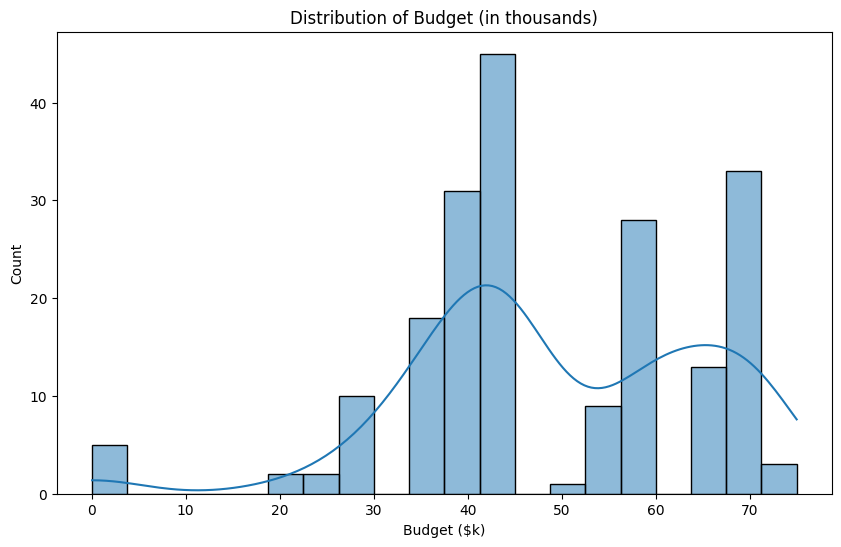

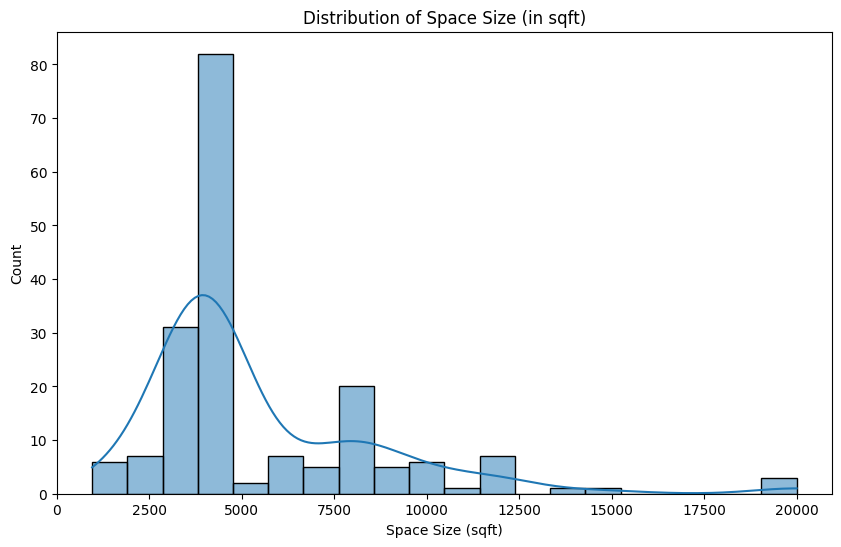

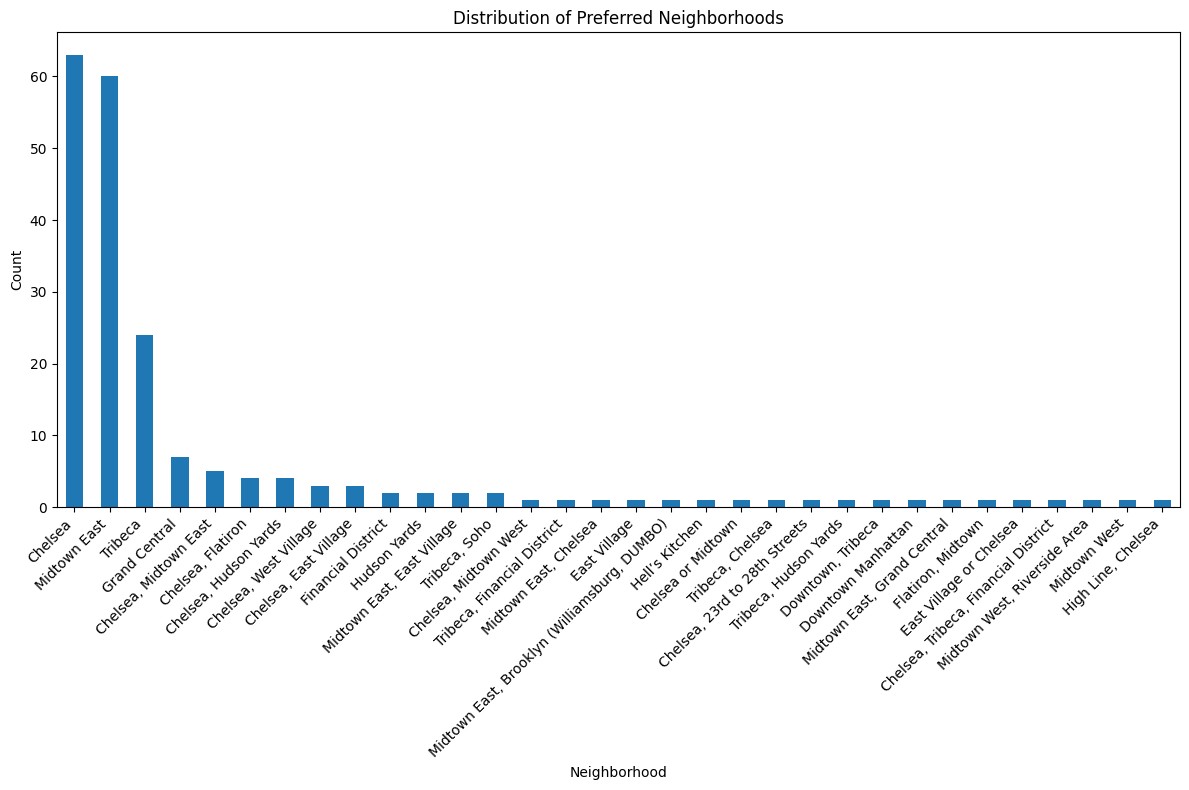

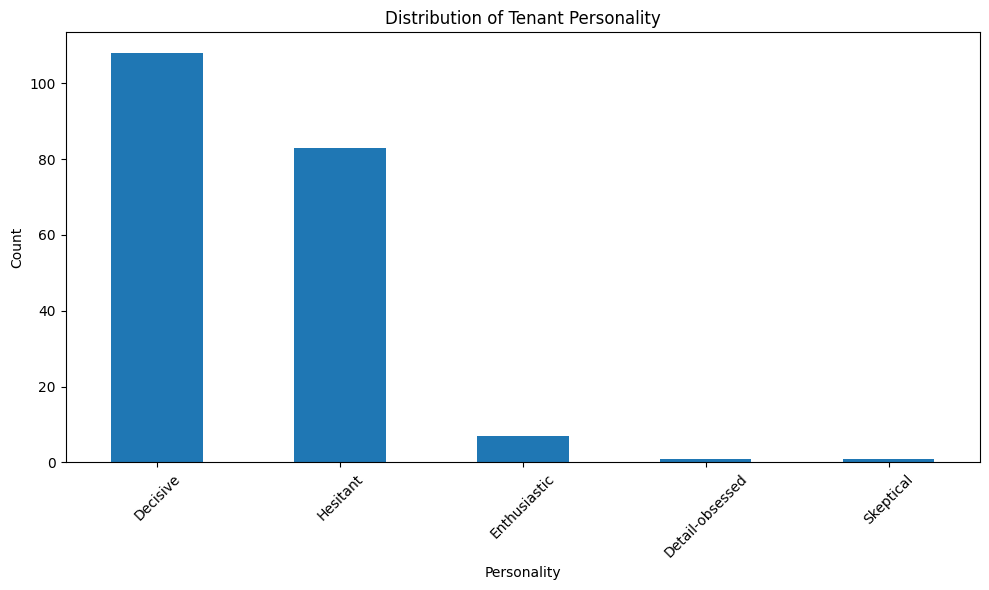

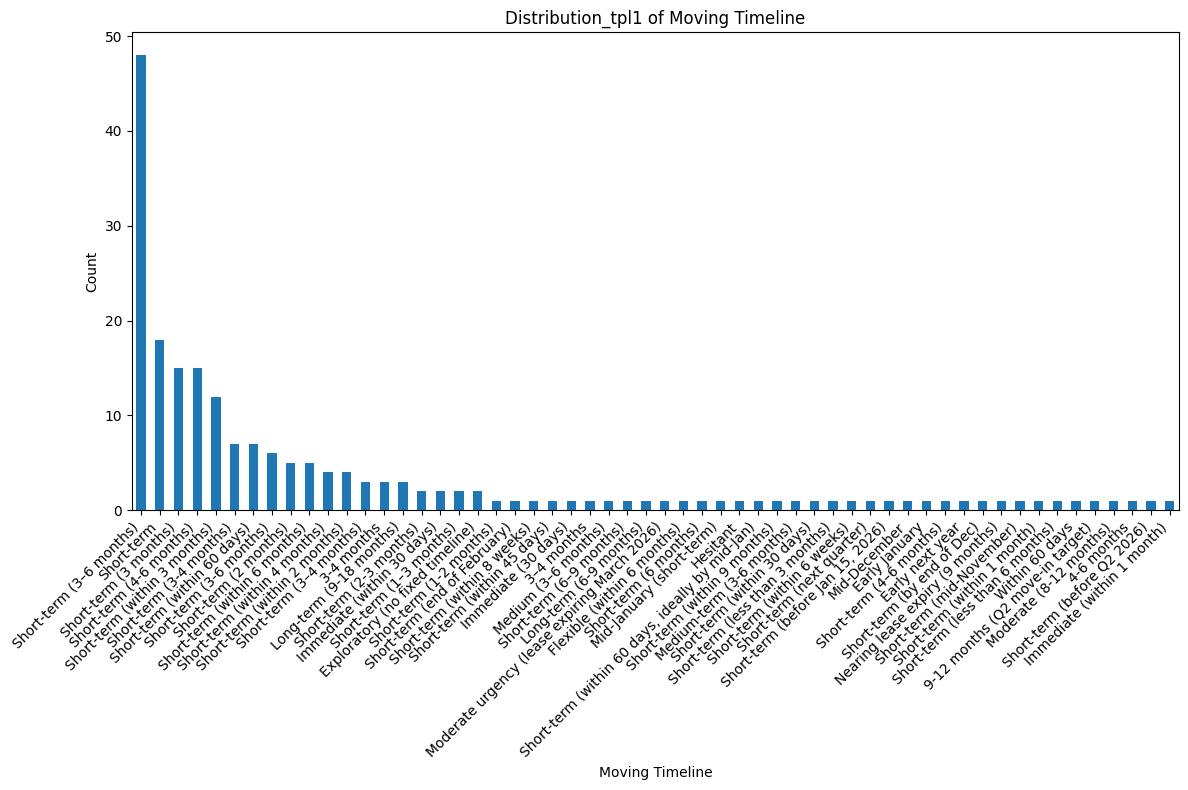

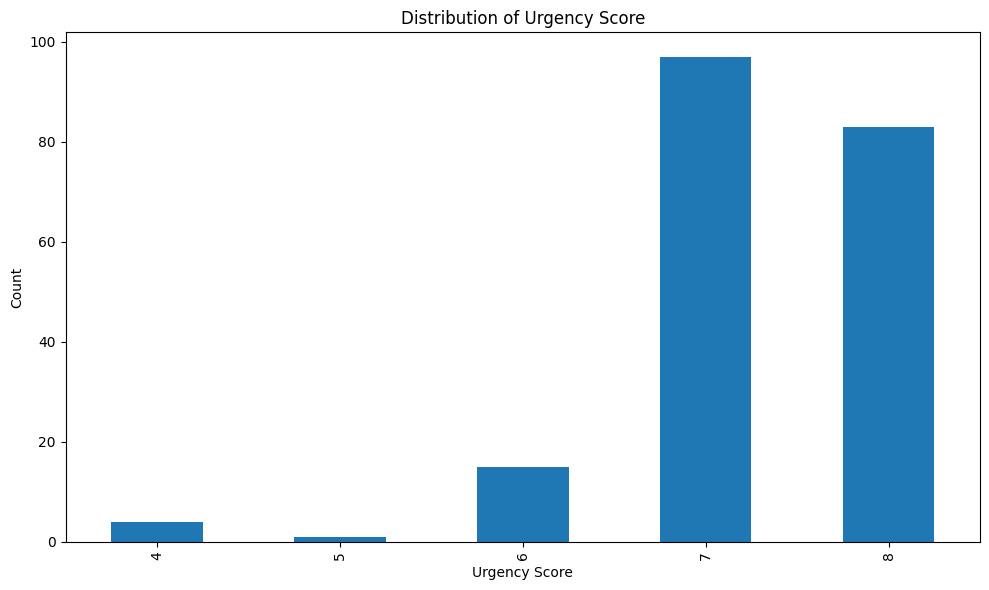

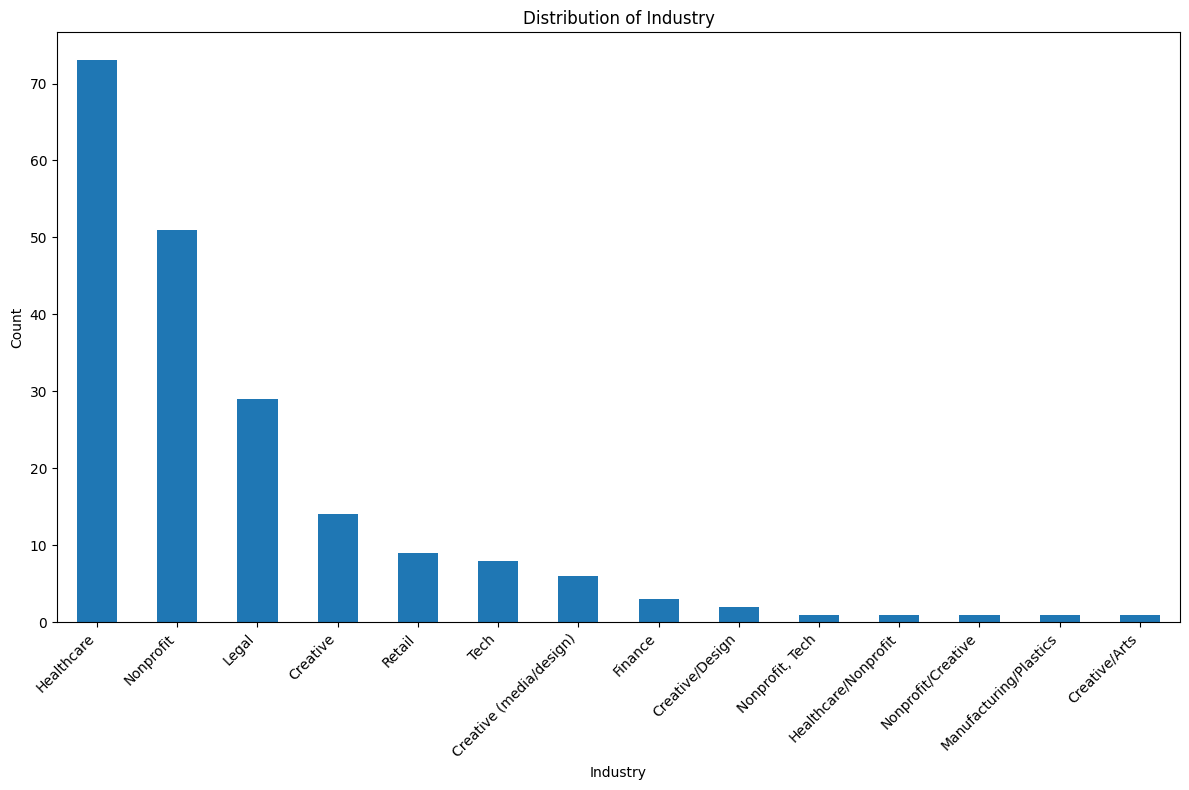

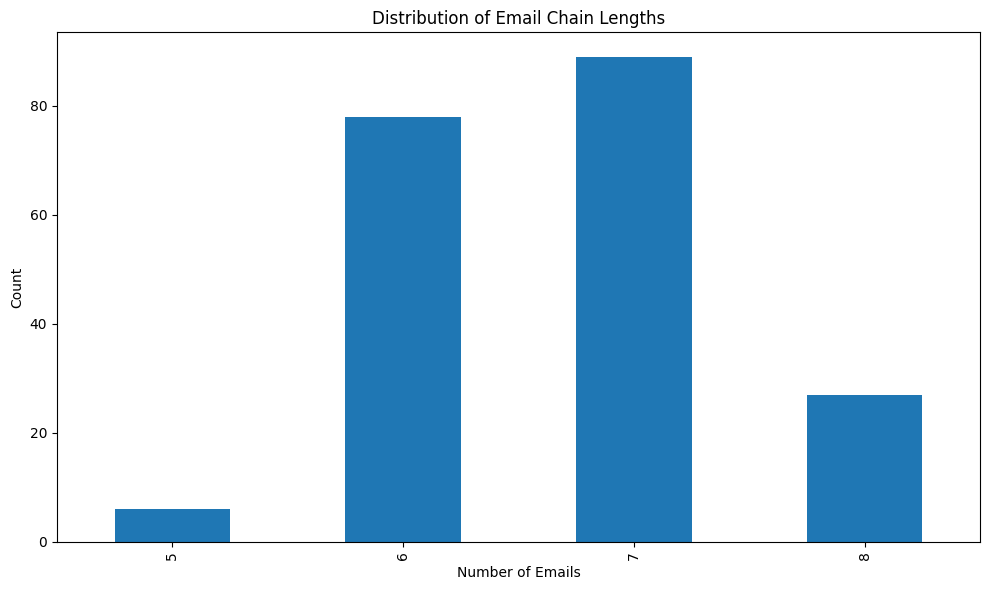

In [41]:
# Visualize distributions
visualize_distributions(results)

In [44]:
# Print summary
print("Dataset Diversity Summary:")
print(f"Number of chains: {results['num_chains']}")
for entity, dist in results["entity_distributions"].items():
    print(f"\n{entity}:")
    print(f"  Unique values: {dist['unique'] if 'unique' in dist else dist['unique_raw']}")
    print(f"  Missing values: {dist['missing']}")
    if entity in ["Budget", "SpaceSize"]:
        print(f"  Mean (normalized): {dist['normalized_mean']:.2f}")
        print(f"  Std (normalized): {dist['normalized_std']:.2f}")
        print(f"  Range (normalized): [{dist['normalized_min']}, {dist['normalized_max']}]")
    else:
        top_10 = sorted(dist["counts"].items(), key=lambda x: x[1], reverse=True)[:10]
        print("  Top 10 values:")
        for value, count in top_10:
            print(f"    {value}: {count}")

print("\nEmail Chain Length:")
print(f"  Mean: {results['email_chain_length']['mean']:.2f}")
print(f"  Std: {results['email_chain_length']['std']:.2f}")
print(f"  Range: [{results['email_chain_length']['min']}, {results['email_chain_length']['max']}]")

Dataset Diversity Summary:
Number of chains: 200

Budget:
  Unique values: 41
  Missing values: 0
  Mean (normalized): 49.40
  Std (normalized): 15.65
  Range (normalized): [0.05, 75]

Neighborhood:
  Unique values: 32
  Missing values: 0
  Top 10 values:
    Chelsea: 63
    Midtown East: 60
    Tribeca: 24
    Grand Central: 7
    Chelsea, Midtown East: 5
    Chelsea, Flatiron: 4
    Chelsea, Hudson Yards: 4
    Chelsea, East Village: 3
    Chelsea, West Village: 3
    Financial District: 2

SpaceSize:
  Unique values: 52
  Missing values: 0
  Mean (normalized): 5476.36
  Std (normalized): 3242.15
  Range (normalized): [950, 20000]

Personality:
  Unique values: 5
  Missing values: 0
  Top 10 values:
    Decisive: 108
    Hesitant: 83
    Enthusiastic: 7
    Detail-obsessed: 1
    Skeptical: 1

MovingTimeline:
  Unique values: 56
  Missing values: 0
  Top 10 values:
    Short-term (3–6 months): 48
    Short-term: 18
    Short-term (3 months): 15
    Short-term (4-6 months): 15
    Sho